GoingDeeper 4. Object Detection
--------------------------

In [1]:
! cd ~/aiffel/object_detection/keras-retinanet
! git clone https://github.com/fizyr/keras-retinanet.git
! cd keras-retinanet && python setup.py build_ext --inplace
! pip install -r requirements.txt
! pip install .

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 13.47 MiB | 36.38 MiB/s, done.
Resolving deltas: 100% (4200/4200), done.
running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/aiffel/keras-retinanet/.eggs/Cython-0.29.26-py3.7-linux-x86_64.egg/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /aiffel/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/keras_retinanet
creating build/temp.linux-x86_64-3.7/keras_retinanet/utils
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare

### 0. Import

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

print('=3')

=3


### 0-1. 데이터셋 불러오기

In [3]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
# 자율주행 보조장치 Object detection 요구사항
# 1) 사람이 카메라에 감지되면 정지
# 2) 차량이 일정 크기 이상으로 감지되면 정지
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

=3


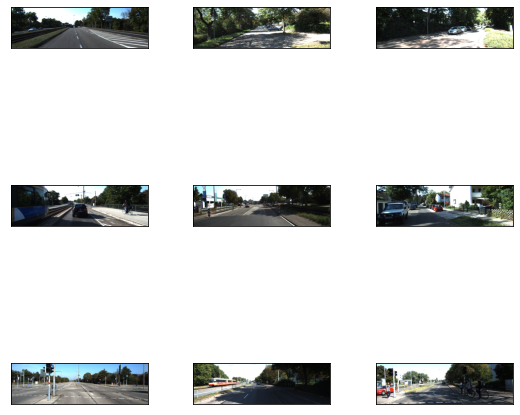

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

- Test로 사용할 kitti 데이터셋에는 Train 6347개, Test 711개 Validation 423개로 나누어져 있습니다.
- 라벨은 alpha, bbox, location, occluded, rotation_y, truncated 등의 정보가 내장되어 있습니다.

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

### 0-2. 데이터셋 확인

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1.58,  2.08,  1.78, -1.51], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.47138667, 0.47376007, 0.5426667 , 0.4955314 ],
       [0.26789334, 0.0534219 , 0.5182667 , 0.20785025],
       [0.45277333, 0.32633656, 0.54642665, 0.366562  ],
       [0.47277334, 0.43785828, 0.54112   , 0.45958132]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1.65, 1.67, 3.64],
       [1.68, 1.67, 3.87],
       [1.87, 1.8 , 4.72],
       [1.61, 1.51, 4.5 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ -0.57,   1.59,  46.82],
       [ -9.09,   1.85,  14.99],
       [-10.22,   1.76,  41.23],
       [ -3.5 ,   1.6 ,  48.14]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 1, 0])>, 'rotation_y': <tf.Tensor: shape=(4,

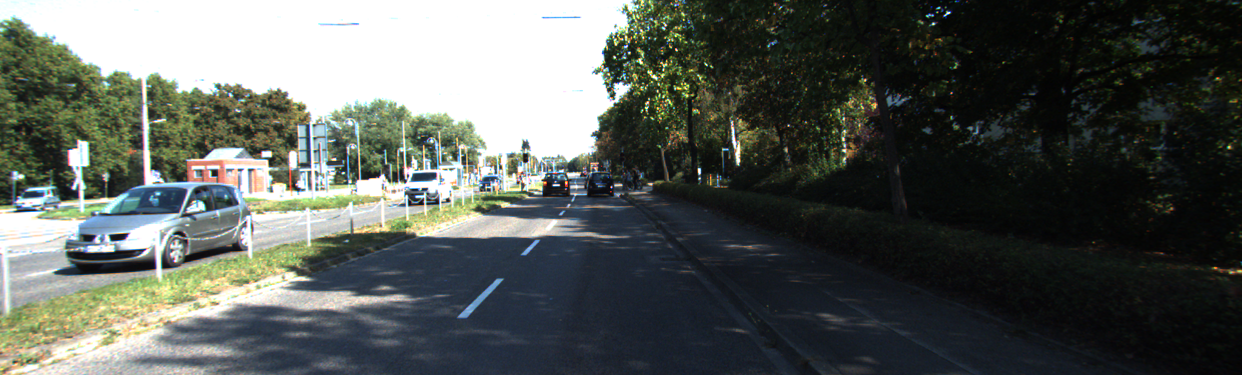

In [6]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(4, 4)
[588.41003 198.23    615.45    171.5    ]
[ 66.35    274.53998 258.15    180.65   ]
[405.31    205.21    455.27002 170.09001]
[543.82    197.70999 570.8     172.08   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F27F05138D0>


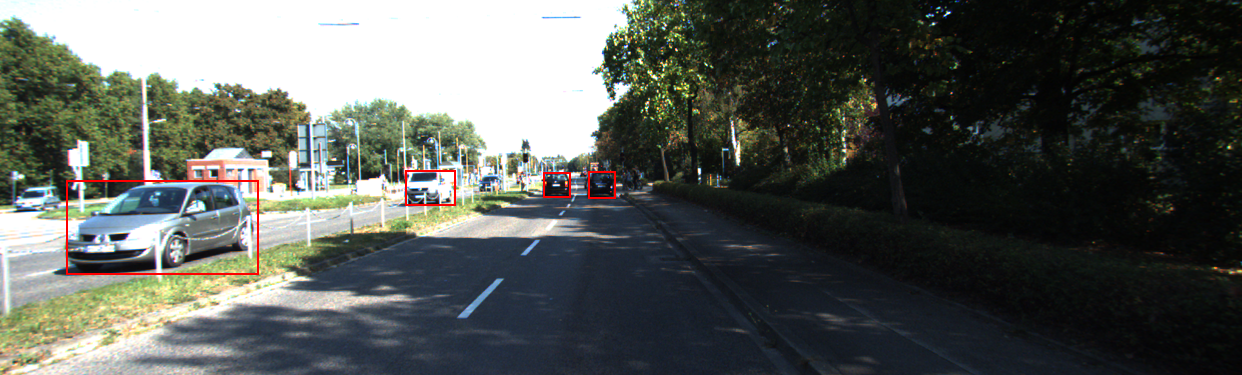

In [7]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### 1-1. 바운딩 박스 정보 추출

In [8]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [24:52<00:00,  4.25it/s]


In [9]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:53<00:00,  4.09it/s]


### 1-2. feature값 맵핑

In [10]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


### 2-1. 훈련 및 저장

In [11]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-12-23 07:15:04.191377: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Traceback (most recent call last):
  File "keras-retinanet/keras_retinanet/bin/train.py", line 38, in <module>
    from ..callbacks.eval import Evaluate
  File "keras-retinanet/keras_retinanet/bin/../../keras_retinanet/callbacks/eval.py", line 18, in <module>
    from ..utils.eval import evaluate
  File "keras-retinanet/keras_retinanet/bin/../../keras_retinanet/utils/eval.py", line 26, in <module>
    import progressbar
ModuleNotFoundError: No module named 'progressbar'
Done


In [12]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-12-23 07:15:07.671765: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-23 07:15:09.422390: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-23 07:15:09.423274: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-23 07:15:09.429837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 07:15:09.430627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-12-23 07:15:09.430671: I tensorflow/stream_executor/platform/default/dso_lo

### 2-2 시각화 이전 작업

In [13]:
mkdir -p ~/aiffel/object_detection/test_set  
wget https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
mv test_set.zip ~/aiffel/object_detection/test_set 
cd ~/aiffel/object_detection/test_set && unzip test_set.zip

--2021-12-23 08:36:15--  https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7547109 (7.2M) [application/zip]
Saving to: ‘test_set.zip’

test_set.zip        100%[===================>]   7.20M  2.43MB/s    in 3.0s    

2021-12-23 08:36:19 (2.43 MB/s) - ‘test_set.zip’ saved [7547109/7547109]

mv: invalid option -- 'y'
Try 'mv --help' for more information.
Archive:  test_set.zip
go_1.png exists and is a symbolic link.
replace go_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### 3. 시각화

In [16]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[593.1908  175.82037 627.52576 205.50284]
[194.72021 131.04543 359.72757 232.63174]
[377.28152 182.93015 417.47037 209.82185]
[531.61646 162.01398 564.6848  191.02217]
[669.17236 158.18884 730.3083  193.91391]


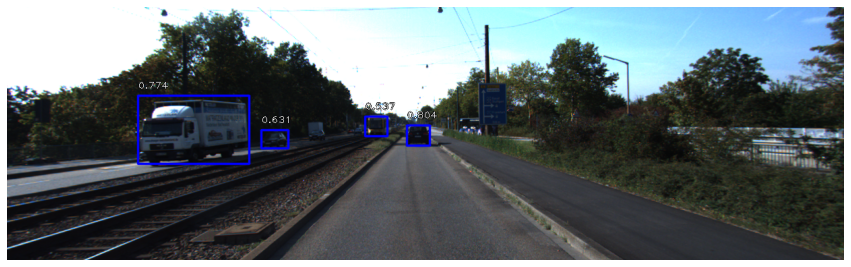

In [17]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

[769.093   137.30807 841.6409  315.4595 ]
[793.9178  138.68483 867.6152  298.53122]


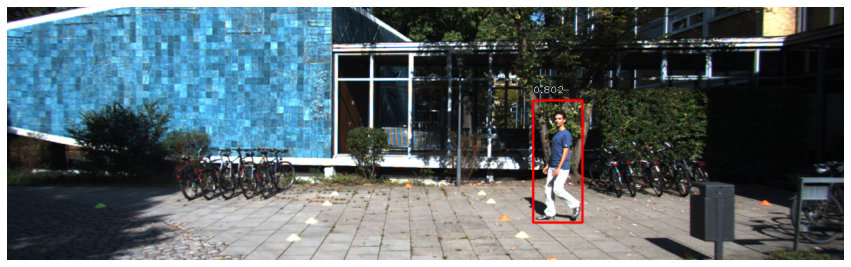

In [18]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

### 4. 자율주행 보조 시스템 테스트

In [30]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.5: break
        if label == 1: return 'Stop'# 사람이 한 명 이상 있는 경우
        elif label == 0: # 자동차가 있는 경우
            # 자동차 크기(너비 또는 높이)가 300px이상일 경우 Stop 반환
            if abs(box[0]-box[2]) >= 300 or abs(box[1]-box[3]) >= 300: return 'Stop'
    
    # 위 2개의 조건 모두 해당하지 않는다면 Go 반환
    return 'Go'

print(self_drive_assist(img_path))

Stop


Stop
[769.093   137.30807 841.6409  315.4595 ]
[793.9178  138.68483 867.6152  298.53122]


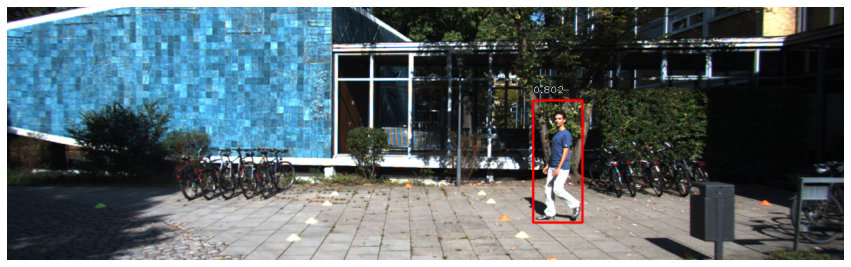

None


In [31]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
print(self_drive_assist(img_path))
print(inference_on_image(model, img_path=img_path))

### 5. 자율주행 시스템 평가

In [35]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.


### 회고
- 정지코드에 대해 깊은 생각을 하게되는 노드였습니다..
- 실제 자율주행 기술로 접목하게 된다면 더 좋은 모델을 사용하여 데이터가 많아야 된다는걸 많이 느꼈습니다.
- 코드를 작성하면서 점점 그래도 발전해 나가는 것 같아서 다행입니다.